In [1]:
import os
import re
from typing import Dict
from datetime import datetime
from IPython.display import Image

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, train_test_split, TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error

import xgboost as xgb
import warnings

# Suppress deprecation warnings
warnings.filterwarnings('ignore')

# Dengue in Singapore: A Predictive Model for NEA

## Table of Contents

1. [Background](#Background)
2. [Approach](#Approach)
3. [Helper Functions](#Helpers)
4. [Data Compilation](#Data-Compilation)
   1. [Dengue](#Data---Dengue)
   2. [Weather](#Data---Weather)
   3. [Google Trends](#Data---Google-Trends)
   4. [Wolbachia and External Events](#Data---Wolbachia-and-External-Events)
   5. [Compiled Dataset](#Compiled-Dataset)
5. [Forecast Models](#Forecast-Models)
    1. [ARIMA/SARIMAX](#ARIMA/SARIMAX)
    2. [Pre- and Post-processing for Tabular Techniques](#Pre--and-Post-processing-for-Tabular-Techniques)
    3. [Linear Regression](#Linear-Regression)
    4. [XGBoost](#XGBoost)
6. [XGBoost Model Refinement](#XGBoost-Model-Refinement)
7. [Wolbachia Effectiveness Investigation](#Wolbachia-Effectiveness-Investigation)
8. [Conclusion and Future Work](#Conclusion-and-Future-Work)

## Background

Dengue fever, transmitted by Aedes mosquitoes, is a significant health issue in Singapore. The National Environment Agency (NEA) combats dengue through initiatives like the BLOCK strategy, which eliminates mosquito breeding sites, and the Wolbachia project, releasing male mosquitoes that prevent eggs from hatching. A predictive model using weather data, Google search trends, and other external events can enhance NEA's dengue management by forecasting weekly case counts over an 8-week window. Linear regression, SARIMAX, and XGBoost are employed in this project to provide accurate forecasts, helping NEA allocate resources and implement preventive measures effectively.

## Approach

The dengue fever forecast model presented herein is trained on a dataset comprising dengue fever records, historical weather conditions, NEA's combat against dengue, external factors like COVID-related lockdowns and increased construction activity, etc. The dataset is compiled using data from various sources including scraped data from [weather.gov](http://www.weather.gov.sg/climate-historical-daily/), [data.gov](https://data.gov.sg/), [NEA](https://www.nea.gov.sg/), etc. Additional data is gathered through desk research to quantify Wolbachia efforts by determining the proportion of Singaporean estates where male Wolbachia-Aedes mosquitoes are released. The impact of COVID-19 related restrictions and subsequent increased post-lockdown construction activity, both of which have influenced dengue cases, is also considered. Details of the data-gathering process is provided in the accompanying notebook `dengue_scraper.ipynb` in the `data` subdirectory.

This notebook outlines the development of models using techniques such as linear regression, SARIMAX, and XGBoost to understand the factors driving dengue cases and plan effective interventions. Ann evaluation of these models to compare their performance is included to determine the most suitable approach for the task.

## Helpers

In [2]:
def get_sequential_predictions(model, X,
                               dict_target_lags: Dict[int, str]):
    '''
    Get predictions using newly predicted labels as lagged labels.
    model: Model with predict method
    X: Features
    dict_target_lags: Dictionary with key as lagged target number, and value as column name of target label.
    '''

    X_pred = X.copy()

    target_lags = list(dict_target_lags.keys())                                                 # Lagged target names
    lag_target_col_names = list(dict_target_lags.values())                                      # Lag values for target
    
    lag_target_col_locs = [X_pred.columns.get_loc(col) for col in lag_target_col_names]         # Integer index locations (use with iloc) of lagged target

    pred_val = np.zeros(X_pred.shape[0])                                                        # Initialize predicted value array

    for i in range(X_pred.shape[0]):
        pred_val[i] = model.predict(X_pred.iloc[i:i+1,:])                                       # Predict current value, keep input in required dataframe format
        for k,j in enumerate(target_lags):                                                      # Add predicted value to X_val as lagged target for subsequent rows
            try:
                X_pred.iloc[i+j,lag_target_col_locs[k]] = pred_val[i]
            except:
                continue
            
    pred_val = np.round(pred_val)                                                               # Round numbers to integers
    pred_val = np.clip(pred_val, 0, 10000000)                                                   # Clip numbers to keep positive and prevent extreme values
    
    return pred_val

def year_week_to_date(row):
    # Convert year and week to datetime format
    year = str(row["Year"])[:-2]
    week = str(row["Week"])[:-2]
    date = f"{year}-{week}-1"
    dt = datetime.strptime(date, "%Y-%W-%w")
    return dt

## Data Compilation

Loading all data for cleaning and compiling. We consider data from 2012 to present (i.e. July 2024) for this project.

In [3]:
datapath = r'./assets/'

# Dengue
df_dengue_datagov_raw = pd.read_csv(os.path.join(datapath,'datagov_dengue.csv'))
df_dengue_jao_raw = pd.read_csv(os.path.join(datapath,'jao_dengue.csv'))
df_dengue_NEA_raw = pd.read_csv(os.path.join(datapath,'NEA_dengue.csv'))

# Weather
# df_weather_datagov_raw = pd.read_csv(os.path.join(datapath,'datagov_weather.csv'))
df_weather_NEA_raw = pd.read_csv(os.path.join(datapath,'NEA_weather.csv'))
df_weather_datagov_RH_raw = pd.read_csv(os.path.join(datapath,'datagov_RH.csv'))

# Google trend
df_trend_dengue_raw = pd.read_csv(os.path.join(datapath,'google_trend_dengue.csv'))
df_trend_dengue_symptoms_raw = pd.read_csv(os.path.join(datapath,'google_trend_dengue_symptoms.csv'))
df_trend_fever_raw = pd.read_csv(os.path.join(datapath,'google_trend_fever.csv'))
df_trend_mosquito_raw = pd.read_csv(os.path.join(datapath,'google_trend_mosquito.csv'))

# Wolbachia
df_wolbachia_raw = pd.read_csv(os.path.join(datapath,'wolbachia_ratio.csv'))

### Data - Dengue

We first clean and compile the available __dengue__ data. Most years have 52 or 53 weeks, while 2024 only has 27 weeks so far. 2019 has some missing entries which will require some imputation later.

In [4]:
# Clean and compile dengue data
df_dengue_datagov = df_dengue_datagov_raw.copy()
df_dengue_datagov.rename(columns={'year':'Year','eweek':'Week','number':'Dengue_Count'}, inplace=True)    # Rename columns for consistency
df_dengue_datagov = df_dengue_datagov.groupby(['Year','Week']).sum()                                      # Combine normal dengue cases and hemorrhagic cases
df_dengue_datagov = df_dengue_datagov.drop(columns='type_dengue').reset_index()                           # Drop dengue fever type

df_dengue_jao = df_dengue_jao_raw.copy()
df_dengue_jao.rename(columns={'Week No.':'Week', 'Dengue (Count)':'Dengue_Count'},inplace=True)           # Rename columns for consistency
df_dengue_jao.drop(columns=['Daily Rainfall Total (mm)','Mean Temperature (C)'],inplace=True)

df_dengue_NEA = df_dengue_NEA_raw.copy()
df_dengue_NEA = df_dengue_NEA.reset_index()
df_dengue_NEA.drop(columns='Unnamed: 0',inplace=True)
df_dengue_NEA = pd.melt(df_dengue_NEA, id_vars=['index','week'],
                        value_vars=['2020','2021','2022','2023','2024'],
                        var_name='Year', value_name='Dengue_Count')                                       # Gathering into long format for consistency
df_dengue_NEA.drop(columns=['index'],inplace=True)
df_dengue_NEA.rename(columns={'week':'Week'},inplace=True)                                                # Rename columns for consistency

df_dengue = pd.concat([df_dengue_datagov,df_dengue_NEA,df_dengue_jao],axis=0)                             # Compiling all dengue datasets into single dataframe
df_dengue.dropna(inplace=True)                                                                            # Dropping small number of missing values
df_dengue = df_dengue.astype({'Year':'int', 'Dengue_Count':'int'})                                        # Converting to standard dtypes
df_dengue.drop_duplicates(subset=['Year','Week'],inplace=True)                                            # Dropping duplicate entries from different data sources
df_dengue.sort_values(by=['Year','Week'],inplace=True)                                                    # Sort in chronological order
df_dengue.groupby(['Year']).count()

,Week,Dengue_Count
Year,,
2012,52,52
2013,52,52
2014,53,53
2015,53,53
2016,53,53
2017,53,53
2018,53,53
2019,47,47
2020,53,53


### Data - Weather

Next, we clean and compile the __weather__ data. Most of the weather data has been scraped from NEA. Missing data was encoded as -1 in this dataset. As shown, the NEA dataset contains daily weather information information from multiple weather stations.

In [5]:
df_weather_NEA = df_weather_NEA_raw.copy()
df_weather_NEA.sample(5)

,Unnamed: 0,Station,Year,Month,Day,Daily Rainfall Total (mm),Highest 30 min Rainfall (mm),Highest 60 min Rainfall (mm),Highest 120 min Rainfall (mm),Mean Temperature (°C),Maximum Temperature (°C),Minimum Temperature (°C),Mean Wind Speed (km/h),Max Wind Speed (km/h)
218862,7,Marine Parade,2022,4,8,0.0,0.0,0.0,0.0,-1.0,-1.0,-1.0,-1.0,-1.0
153122,0,Kranji Reservoir,2023,8,1,0.0,0.0,0.0,0.0,-1.0,-1.0,-1.0,-1.0,-1.0
102555,11,Tai Seng,2020,11,12,0.0,0.0,0.0,0.0,29.9,34.0,27.6,10.4,35.9
186323,29,Sentosa Island,2018,6,30,0.0,0.0,0.0,0.0,28.0,30.7,26.5,6.8,22.3
221013,4,Tengah,2021,2,5,0.0,0.0,0.0,0.0,-1.0,32.6,24.0,-1.0,33.3


Our dengue dataset above provides weekly dengue counts for the whole of Singapore. To match the dengue dataset, we take the mean values for the different weather conditions across different weather stations and over the week. Note that the highest rainfall columns consist of more than 100 missing values.

In [6]:
# Get week of year
df_weather_NEA = df_weather_NEA.replace(-1, np.nan)                                     # Encode missing values as NaN
df_weather_NEA.drop(columns=['Unnamed: 0'],inplace=True)                                # Drop index column
df_weather_NEA.dropna(subset=['Year','Month','Day'],inplace=True)                       # Dropping records where the date in missing
df_weather_NEA = df_weather_NEA.astype({'Year':'int','Month':'int','Day':'int'})        # Convert to date time and extract week of year
df_weather_NEA['date'] = pd.to_datetime(df_weather_NEA[['Year', 'Month', 'Day']])
df_weather_NEA['Week'] = df_weather_NEA['date'].dt.isocalendar().week
df_weather_NEA.drop(columns=['Day','date','Month','Station'],inplace=True)              # Drop obsolete columns

# Renaming columns for convenience.
df_weather_NEA.rename(columns={'Daily Rainfall Total (mm)':'Daily_Rainfall',
                               'Highest 30 min Rainfall (mm)':'Highest_30mm_Rain',
                               'Highest 60 min Rainfall (mm)':'Highest_60mm_Rain',
                               'Highest 120 min Rainfall (mm)':'Highest_120mm_Rain',
                               'Mean Temperature (°C)':'Mean_Temperature',
                               'Maximum Temperature (°C)':'Max_Temperature',
                               'Minimum Temperature (°C)':'Min_Temperature',
                               'Mean Wind Speed (km/h)':'Min_Wind_Speed',
                               'Max Wind Speed (km/h)':'Max_Wind_speed'},inplace=True)

# Taking mean values over all stations and over all days of a given week
df_weather_NEA = df_weather_NEA.groupby(['Year','Week']).mean()

# Check for missing values.
print(df_weather_NEA.info())

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 654 entries, (2012, 1) to (2024, 26)
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Daily_Rainfall      654 non-null    float64
 1   Highest_30mm_Rain   550 non-null    float64
 2   Highest_60mm_Rain   550 non-null    float64
 3   Highest_120mm_Rain  550 non-null    float64
 4   Mean_Temperature    654 non-null    float64
 5   Max_Temperature     654 non-null    float64
 6   Min_Temperature     654 non-null    float64
 7   Min_Wind_Speed      654 non-null    float64
 8   Max_Wind_speed      654 non-null    float64
dtypes: float64(9)
memory usage: 47.7 KB
None


We drop highest 30mm, 60mm and 120mm rainfall columns for simplicity.

In [7]:
df_weather_NEA.drop(columns=[col for col in df_weather_NEA if ('Highest' in col)], inplace=True)
df_weather_NEA = df_weather_NEA.reset_index()

Humidity is well-known to be correlated with dengue fever but not provided by the NEA source. Therefore, we additionally look at relative humidity data from a separate dataset obtained from data.gov.sg.

In [8]:
# Get relative humidity dataframe
df_RH_datagov = df_weather_datagov_RH_raw.copy()
df_RH_datagov.sample(5)

,month,mean_rh
59,2016-12,72.8
44,2015-09,75.0
99,2020-04,76.4
143,2023-12,82.7
122,2022-03,79.2


 As shown, this dataset provides only monthly values. We assume that the relative humidity is constant over each month and fill in the missing values for each week accordingly.

In [9]:
# Fill in values for each week of year
df_RH_datagov['Year'] = pd.to_datetime(df_weather_datagov_RH_raw.month).dt.isocalendar().year           # Create year column
df_RH_datagov['Week'] = pd.to_datetime(df_weather_datagov_RH_raw.month).dt.isocalendar().week           # Create week column
df_RH_datagov.drop(columns=['month'],inplace=True)
df_RH_datagov.rename(columns={'mean_rh':'Relative_Humidity'},inplace=True)
df_weeks_temp = df_weather_NEA[['Year','Week']]                                                         # Get weeks of year over range of years considered
df_RH_datagov = df_RH_datagov.merge(df_weeks_temp,on=['Year','Week'],how='outer')
df_RH_datagov.ffill(inplace=True)                                                                       # Assume same humidity over all weeks of month

The relative humidity dataframe is merged into the weather dataframe to give the complete weather features required.

In [10]:
# Merge relative humidity data into other weather data
df_weather = df_weather_NEA.merge(df_RH_datagov,on=['Year','Week'],how='left')
df_weather.sample(5)

,Year,Week,Daily_Rainfall,Mean_Temperature,Max_Temperature,Min_Temperature,Min_Wind_Speed,Max_Wind_speed,Relative_Humidity
61,2013,10,6.152459,27.805797,31.977857,25.210000,9.762857,35.928571,80.4
472,2021,2,2.733025,26.127586,29.435772,24.100813,11.842202,38.322609,82.6
275,2017,14,5.892098,28.113913,31.684483,24.973276,7.894262,36.382787,83.5
455,2020,38,5.669167,27.684545,31.520000,24.599130,8.471930,37.784298,79.0
159,2015,4,2.903695,26.758647,30.668421,24.481203,11.889683,35.082540,77.6


### Data - Google Trends

Next, __google search trends__ regarding dengue may indicate imminent occurence of dengue clusters. Specifically, we include search trends related to the keywords "dengue", "dengue+symptoms", "fever", and "mosquito".

In [11]:
# Renaming columns
df_trend_dengue = df_trend_dengue_raw.copy()
df_trend_dengue_symptoms = df_trend_dengue_symptoms_raw.copy()
df_trend_fever = df_trend_fever_raw.copy()
df_trend_mosquito = df_trend_mosquito_raw.copy()

df_trend_dengue.rename(columns={'dengue: (Singapore)':'Trend_Dengue'},inplace=True)
df_trend_dengue_symptoms.rename(columns={'dengue symptoms: (Singapore)':'Trend_Dengue_Symptoms'},inplace=True)
df_trend_fever.rename(columns={'fever: (Singapore)':'Trend_Fever'},inplace=True)
df_trend_mosquito.rename(columns={'mosquito: (Singapore)':'Trend_Mosquito'},inplace=True)

# Get week and year
df_trend_dengue['Year'] = pd.to_datetime(df_trend_dengue['Week']).dt.isocalendar().year
df_trend_dengue['Week'] = pd.to_datetime(df_trend_dengue['Week']).dt.isocalendar().week
df_trend_dengue_symptoms['Year'] = pd.to_datetime(df_trend_dengue_symptoms['Week']).dt.isocalendar().year
df_trend_dengue_symptoms['Week'] = pd.to_datetime(df_trend_dengue_symptoms['Week']).dt.isocalendar().week
df_trend_fever['Year'] = pd.to_datetime(df_trend_fever['Week']).dt.isocalendar().year
df_trend_fever['Week'] = pd.to_datetime(df_trend_fever['Week']).dt.isocalendar().week
df_trend_mosquito['Year'] = pd.to_datetime(df_trend_mosquito['Week']).dt.isocalendar().year
df_trend_mosquito['Week'] = pd.to_datetime(df_trend_mosquito['Week']).dt.isocalendar().week


# Combining into one dataframe
df_trends = df_trend_dengue.merge(df_trend_dengue_symptoms,how='left',on=['Week','Year'])
df_trends = df_trends.merge(df_trend_fever,how='left',on=['Week','Year'])
df_trends = df_trends.merge(df_trend_mosquito,how='left',on=['Week','Year'])
df_trends.drop_duplicates(subset=['Year','Week'],inplace=True) # Drop small number of repeated entries
df_trends

,Week,Trend_Dengue,Year,Trend_Dengue_Symptoms,Trend_Fever,Trend_Mosquito
0,52,51,2014,58,72,58
8,1,51,2015,74,71,71
9,2,51,2015,66,74,59
10,3,49,2015,60,69,59
11,4,62,2015,62,70,68
...,...,...,...,...,...,...
800,24,63,2024,59,82,88
801,25,63,2024,77,78,95
802,26,58,2024,76,85,81
803,27,57,2024,73,94,88


### Data - Wolbachia and External Events

External, non-weather events may directly influence dengue incidence. In particular, __Project Wolbachia__ to curb dengue spread may have reduced dengue cases. Here, we consider Wolbachia efforts as the numerical feature `Wolbachia` given by the percentage of Singapore districts with Wolbachia release.

In [12]:
df_wolbachia = df_wolbachia_raw.drop(columns=['Wolbachia_Areas'])
df_wolbachia.sample(5)

,Year,Week,Wolbachia_Ratio
65,2013,14,0.000000
325,2018,10,0.036364
416,2019,48,0.036364
201,2015,45,0.000000
383,2019,15,0.036364


Additionally, __Covid-19 restrictions and increased construction activities__ after restrictions are lifted may have caused a rise in cases. The presence of such restrictions/activities are encoded as a categorical feature `External_Events` here.

In [13]:
df_external_events = df_wolbachia[['Year','Week']]
df_external_events['External_Events'] = 0
df_external_events.loc[(df_external_events.Year==2020) & (df_external_events.Week>=15) & (df_external_events.Week<=30),'External_Events'] = 1       # Period of high COVID restrictions, start of lockdown: 7th April 2020, end of phase 2: 17th July
df_external_events.loc[(df_external_events.Year==2022) & (df_external_events.Week>=10) & (df_external_events.Week<=40),'External_Events'] = 1       # Period of increased construction activity in 2022 between weeks 10 and 40

### Compiled Dataset

We combined all data we have into a single dataframe. Visualizing all missing data below, we see that most of them are due to consideration of a 53rd week of the year. As mentioned earlier, some weeks in 2019 are also missing dengue fever counts.

In [14]:
df_raw = df_dengue.merge(df_weather,on=['Year','Week'],how='outer').merge(df_trends,on=['Year','Week'],how='outer')
df_raw = df_raw.merge(df_wolbachia,on=['Year','Week'],how='left')
df_raw = df_raw.merge(df_external_events,on=['Year','Week'],how='left')
display(df_raw[df_raw.isna().any(axis=1)])   # Show rows with missing values

,Year,Week,Dengue_Count,Daily_Rainfall,Mean_Temperature,Max_Temperature,Min_Temperature,Min_Wind_Speed,Max_Wind_speed,Relative_Humidity,Trend_Dengue,Trend_Dengue_Symptoms,Trend_Fever,Trend_Mosquito,Wolbachia_Ratio,External_Events
0,2011,52,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,64.0,72.0,87.0,68.0,NaN,NaN
157,2014,53,158.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.0
263,2016,53,0.0,9.947647,26.211667,27.990000,24.400000,7.458333,34.603333,84.8,NaN,NaN,NaN,NaN,0.036364,0.0
316,2017,53,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.036364,0.0
369,2018,53,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.036364,0.0
417,2019,48,NaN,13.375069,27.664486,32.569027,25.070796,7.818033,33.086066,83.9,40.0,39.0,76.0,72.0,0.036364,0.0
418,2019,49,NaN,6.549143,27.418868,30.736036,25.310811,11.496610,39.640678,83.9,40.0,40.0,76.0,67.0,0.036364,0.0
419,2019,50,NaN,27.321003,25.009091,27.382692,23.375000,9.198214,32.920536,83.9,39.0,35.0,88.0,70.0,0.036364,0.0
420,2019,51,NaN,5.785920,26.448889,30.261458,24.387500,8.639167,30.013333,83.9,43.0,57.0,95.0,68.0,0.036364,0.0
421,2019,52,NaN,2.205525,27.395050,31.543925,25.035514,10.892683,33.669106,83.9,22.0,28.0,56.0,64.0,0.036364,0.0


Here, we:
1. drop 53rd week from each year
2. fill the missing values with `.ffill` methods.

In [15]:
# Final touches
df_raw = df_raw.loc[df_raw['Week']!=53]                           # Drop all week 53s
df_raw.ffill(inplace=True)                                        # Fill missing values
df_raw.dropna(inplace=True)                                       # Remove straggling row with missing values
df_raw = df_raw.astype({'Week':'int','Year':'int'})               # Ensure clean datatypes
df_raw['Date'] = df_raw.apply(lambda row: year_week_to_date(row),axis=1) # Use datetime indexing on compiled dataframe
df_raw.set_index('Date',inplace=True)

To evaluate the performance of the models below, we use a cross-validation approach appropriate for time series data, known as a time series split using `sklearn.model_selection.TimeSeriesSplit`. Here we forecast for a window of 8 weeks. The difference between this approach and the usual K-fold cross-validation approach is illustrated by [Assaad and Fayek, 2012](https://www.researchgate.net/publication/355889701_Predicting_the_Price_of_Crude_Oil_and_its_Fluctuations_Using_Computational_Econometrics_Deep_Learning_LSTM_and_Convolutional_Neural_Networks) and reproduced below.

![K-fold Cross Validation vs Time Series Split](../assets/timeseriessplit.png)

We create the tscv approach which will perform the required splits and return an iterator of the train and test indices required.

In [16]:
# Split into train and test sets
forecast_window = 8
tscv = TimeSeriesSplit(n_splits=68, test_size=forecast_window)

## Exploratory Data Analysis (EDA)

The compiled dataset used consists of weather conditions, google search trends, as well as indicators for Wolbachia and any external events.

In [17]:
# Create copy of main dataframe and show structure
df_plot = df_raw.copy()
df_plot.sample(5)

,Year,Week,Dengue_Count,Daily_Rainfall,Mean_Temperature,Max_Temperature,Min_Temperature,Min_Wind_Speed,Max_Wind_speed,Relative_Humidity,Trend_Dengue,Trend_Dengue_Symptoms,Trend_Fever,Trend_Mosquito,Wolbachia_Ratio,External_Events
Date,,,,,,,,,,,,,,,,
2012-09-10,2012,37,74.0,1.135952,28.107857,30.898571,25.735714,7.225180,31.783453,79.7,53.0,43.0,69.0,95.0,0.000000,0.0
2018-12-10,2018,50,108.0,12.437243,26.756881,31.012931,24.533621,6.651724,30.537069,81.5,47.0,49.0,92.0,71.0,0.036364,0.0
2018-07-30,2018,31,51.0,3.433511,27.699083,30.463793,25.604310,8.509756,31.808130,77.0,38.0,36.0,71.0,80.0,0.036364,0.0
2020-08-10,2020,32,1664.0,0.614409,29.125000,32.363025,26.805042,8.797479,30.008130,76.8,64.0,74.0,31.0,81.0,0.090909,0.0
2018-05-21,2018,21,65.0,8.504032,28.160377,32.130088,25.322124,7.296748,28.902439,79.0,47.0,57.0,76.0,89.0,0.036364,0.0


As shown below, there are no missing values in the dataset.

In [18]:
# Show dataset datatypes and check for missing values
df_plot.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 652 entries, 2012-01-02 to 2024-07-08
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Year                   652 non-null    int64  
 1   Week                   652 non-null    int64  
 2   Dengue_Count           652 non-null    float64
 3   Daily_Rainfall         652 non-null    float64
 4   Mean_Temperature       652 non-null    float64
 5   Max_Temperature        652 non-null    float64
 6   Min_Temperature        652 non-null    float64
 7   Min_Wind_Speed         652 non-null    float64
 8   Max_Wind_speed         652 non-null    float64
 9   Relative_Humidity      652 non-null    float64
 10  Trend_Dengue           652 non-null    float64
 11  Trend_Dengue_Symptoms  652 non-null    float64
 12  Trend_Fever            652 non-null    float64
 13  Trend_Mosquito         652 non-null    float64
 14  Wolbachia_Ratio        652 non-null    

First, we look into the trends of dengue fever over the years. As shown, most years show a peak in the middle of the year, with years 2019, 2020 and 2022 showing higher than usual dengue fever cases, possibly related to Covid related lockdown. Year 2023 again shows lower dengue fever cases as lockdown restrictions are lifted.

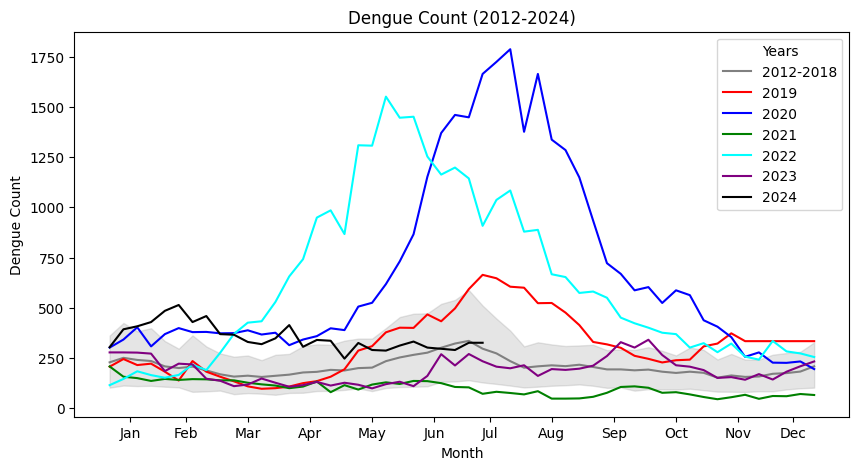

In [19]:
# Create the line plot
fig, ax = plt.subplots(1,1,figsize=(10,5))
key_years = [2019,2020,2021,2022,2023,2024]
df_plot['Years'] = df_plot['Year'].apply(lambda x: str(x) if x in key_years else '2012-2018')
palette = {'2012-2018': 'gray', '2019': 'red', '2020':'blue','2021':'green','2022':'cyan','2023':'purple','2024':'black'}
sns.lineplot(data=df_plot, x='Week', y='Dengue_Count', hue='Years', palette=palette, legend=True,ax=ax)
month_labels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
month_ticks = [2.5,6.5,11,15.5,20,24.5,28.5,33,37.5,42,46.5,50.5]
ax.set_xticks(month_ticks)
ax.set_xticklabels(month_labels)
ax.set_xlabel('Month')
ax.set_ylabel('Dengue Count')
ax.set_title('Dengue Count (2012-2024)');


Using a heatmap of linear correlation, we look at the relationship between dengue cases and the different temperature conditions. We see some correlation with temperature and relative humidity. However, linear relationships may not fully capture the complexity of dengue incidence in response to weather changes. In particular, dengue cases may be related to past weather conditions, as an Aedes egg can take 7 to 10 days to hatch and develop into an adult mosquito. Such relationships can be more properly explored in via statistical modelling.

<Axes: >

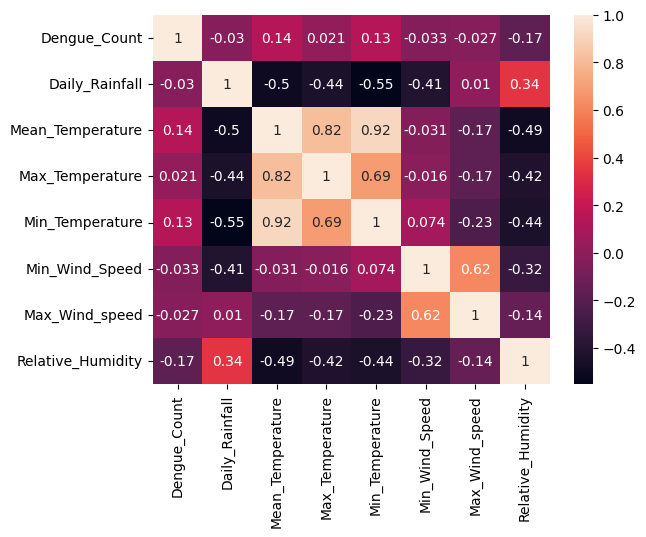

In [20]:
sns.heatmap(df_plot[['Dengue_Count','Daily_Rainfall', 'Mean_Temperature',
       'Max_Temperature', 'Min_Temperature', 'Min_Wind_Speed',
       'Max_Wind_speed','Relative_Humidity']].corr(),annot=True)

Finally, we see if there is a relationship between google search trends on Dengue and incidence of Dengue fever. As shown, there is a strong correlation between search for Dengue symptoms and Dengue fever incidence.

<Axes: >

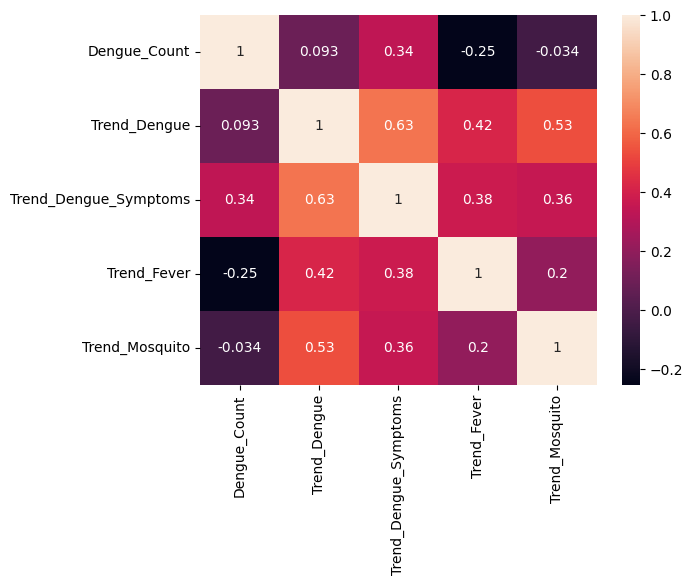

In [21]:
sns.heatmap(df_plot[['Dengue_Count','Trend_Dengue', 'Trend_Dengue_Symptoms','Trend_Fever','Trend_Mosquito']].corr(),annot=True)

Finally, we look at the effect of external events with similar plot, showing a strong correlation with external events.

<Axes: >

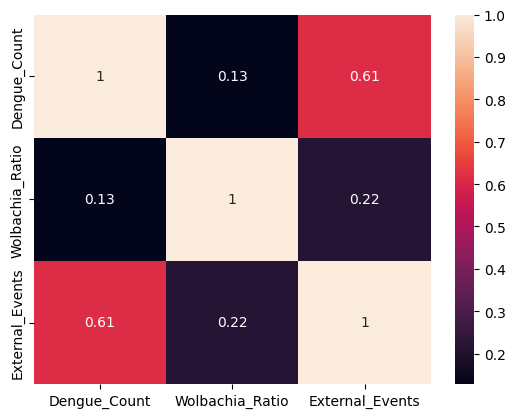

In [22]:
sns.heatmap(df_plot[['Dengue_Count','Wolbachia_Ratio', 'External_Events']].corr(),annot=True)

## Forecast Models

We investigate three forecasting models to predict future occurrences of dengue fever.

### ARIMA/SARIMAX

### Pre- and Post-processing for Tabular Techniques

Unlike time series modelling methods like ARIMA, techniques like linear regression and XGBoost do not naturally account for past values in the sequence. Further processing is required to create lagged values of the features and/or targets as additional input features to the model. We consider using 5 weeks' worth of past data to predict the dengue counts over the next 8 weeks.

In [23]:
# Create dataframe with lagged values for tabular approach
df_tab = df_raw.copy()
target_lags = range(1, 6)                                         # Lagged values to use for target, i.e. dengue count
feature_lags = range(1, 6)                                        # Lagged values to use for features
lagged_features = ['Daily_Rainfall', 'Mean_Temperature', 'Relative_Humidity',
                   'Max_Temperature', 'Min_Temperature', 'Min_Wind_Speed',
                   'Max_Wind_speed', 'Trend_Dengue', 'Trend_Dengue_Symptoms',
                   'Trend_Fever', 'Trend_Mosquito','Wolbachia_Ratio','External_Events']

# Add feature lags
for feat in lagged_features:
    for lag in feature_lags:
        df_tab[f'{feat}_Lag_{lag}'] = df_tab[feat].shift(lag)
        
# Add target lags
dict_target_lags = {}                                             # Keep track of lagged target names
for lag in target_lags:
    dict_target_lags[lag] = f'Dengue_Count_Lag_{lag}'
    df_tab[dict_target_lags[lag]] = df_tab['Dengue_Count'].shift(lag)    

df_tab.head()

,Year,Week,Dengue_Count,Daily_Rainfall,Mean_Temperature,Max_Temperature,Min_Temperature,Min_Wind_Speed,Max_Wind_speed,Relative_Humidity,...,External_Events_Lag_1,External_Events_Lag_2,External_Events_Lag_3,External_Events_Lag_4,External_Events_Lag_5,Dengue_Count_Lag_1,Dengue_Count_Lag_2,Dengue_Count_Lag_3,Dengue_Count_Lag_4,Dengue_Count_Lag_5
Date,,,,,,,,,,,,,,,,,,,,,
2012-01-02,2012,1,74.0,10.266250,26.866026,30.521875,24.589375,10.653125,36.228750,87.3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-01-09,2012,2,66.0,3.740000,26.434783,29.797143,23.925714,8.486429,33.596429,87.3,...,0.0,NaN,NaN,NaN,NaN,74.0,NaN,NaN,NaN,NaN
2012-01-16,2012,3,61.0,13.200000,27.238235,31.835000,24.474286,6.683571,29.836429,87.3,...,0.0,0.0,NaN,NaN,NaN,66.0,74.0,NaN,NaN,NaN
2012-01-23,2012,4,52.0,1.522381,26.784672,30.781429,24.417857,9.255714,33.138571,87.3,...,0.0,0.0,0.0,NaN,NaN,61.0,66.0,74.0,NaN,NaN
2012-01-30,2012,5,85.0,7.472143,26.544286,30.213571,24.176429,9.028571,33.248571,85.6,...,0.0,0.0,0.0,0.0,NaN,52.0,61.0,66.0,74.0,NaN


Prediction using the trained model is similarly not straightforward, as compared to models like ARIMA. For example, when forecasting the target value 8 weeks in the future, we may need to use target values from weeks 3,4,5,6,7 as lagged values. Unfortunately, these values are not known a priori. For a proper model evaluation, we have to use predicted rather than known values for weeks 3,4,5,6,7 as lagged values, entailing a sequential prediction approach. The `get_sequential_predictions` function below perform such a sequential prediction.

In [24]:
def get_sequential_predictions(model, X,
                               dict_target_lags: Dict[int, str]):
    '''
    Get predictions using newly predicted labels as lagged labels.
    model: Model with predict method
    X: Features
    dict_target_lags: Dictionary with key as lagged target number, and value as column name of target label.
    '''

    X_pred = X.copy()

    target_lags = list(dict_target_lags.keys())                                                 # Lagged target names
    lag_target_col_names = list(dict_target_lags.values())                                      # Lag values for target
    
    lag_target_col_locs = [X_pred.columns.get_loc(col) for col in lag_target_col_names]         # Integer index locations (use with iloc) of lagged target

    pred_val = np.zeros(X_pred.shape[0])                                                        # Initialize predicted value array

    for i in range(X_pred.shape[0]):
        pred_val[i] = model.predict(X_pred.iloc[i:i+1,:])                                       # Predict current value, keep input in required dataframe format
        for k,j in enumerate(target_lags):                                                      # Add predicted value to X_val as lagged target for subsequent rows
            try:
                X_pred.iloc[i+j,lag_target_col_locs[k]] = pred_val[i]
            except:
                continue
            
    pred_val = np.round(pred_val)                                                               # Round numbers to integers
    pred_val = np.clip(pred_val, 0, 10000000)                                                   # Clip numbers to keep positive and prevent extreme values
    
    return pred_val

### Linear Regression

### XGBoost

Next, we consider XGBoost for this forecasting task. The process is similar to that for linear regression. We forecast 8-week windows sequentially and compare the predicted values against recorded ones.

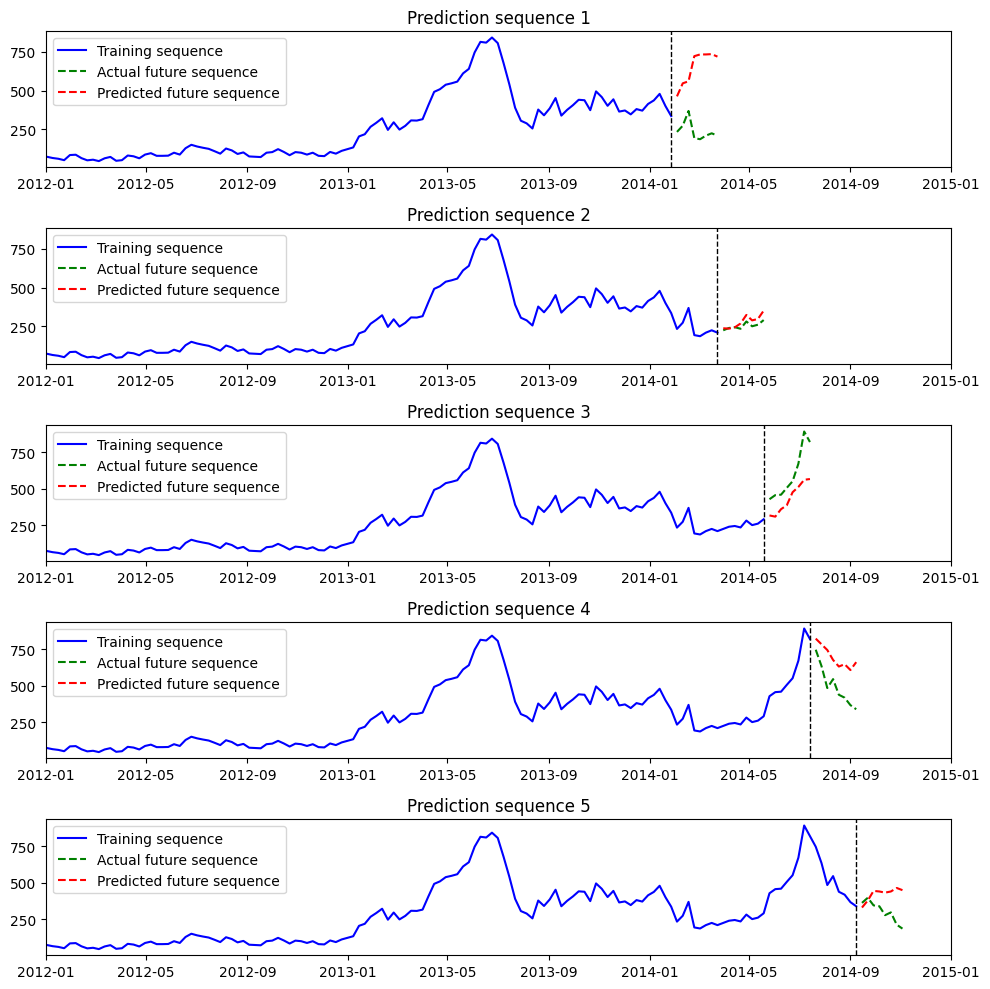

In [25]:
# PLOT FOR PPT, NOT NOTEBOOK. TO REMOVE
# Create feature and target dataframes
df_features = df_tab.copy()[[col for col in df_tab.columns if not (col in ['Year','Dengue_Count'])]]
df_target = df_tab.copy()[['Dengue_Count']]

# Define parameters for XGBoost
params = {
    'learning_rate': 0.1,
    'n_estimators': 1000,
    'max_depth': 8,
    'min_child_weight': 1,
    'gamma': 0.6,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'reg_lambda': 1,
    'reg_alpha': 1,
    'objective': 'reg:squarederror',
    'random_state': 42,
    'device':'cuda',
    'tree_method':'hist'
}

fig,axs = plt.subplots(5,1,figsize=(10,10))
axs = axs.flatten()

# Collect predictions
preds = []
for i, (train_ind,test_ind) in enumerate(tscv.split(df_features)):
    # Initialize XGBoost regressor with defined parameters
    model = xgb.XGBRegressor(**params)

    # Train the model
    model.fit(df_features.iloc[train_ind,:], df_target.iloc[train_ind])

    # Get prediction
    y_pred = get_sequential_predictions(model, df_features.iloc[test_ind,:],
                                    dict_target_lags=dict_target_lags)
    
    y_pred = pd.DataFrame(y_pred,columns=['Dengue_Count'],index=df_features.iloc[test_ind,:].index)

    # Plot train and test sequences
    axs[i].plot(df_target.iloc[train_ind],'b',label='Training sequence')
    axs[i].plot(df_target.iloc[test_ind],'g--',label='Actual future sequence')
    axs[i].plot(y_pred,'r--',label='Predicted future sequence')
    axs[i].set_xlim([datetime(2012, 1, 1),datetime(2015, 1, 1)])
    axs[i].axvline(x=df_features.iloc[train_ind,:].index[-1], color='k', linestyle='--', linewidth=1)
    axs[i].legend()
    axs[i].set_title(f'Prediction sequence {i+1}')

    if i == 4:
        break
fig.tight_layout()

Text(0.5, 1.0, 'Dengue Count Prediction, Forecast Window = 8 weeks, RMSE = 146.8')

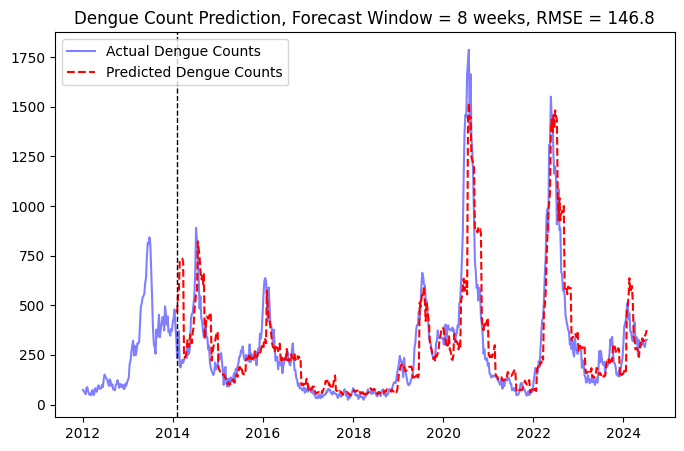

In [26]:
# Create feature and target dataframes
df_features = df_tab.copy()[[col for col in df_tab.columns if not (col in ['Year','Dengue_Count'])]]
df_target = df_tab.copy()[['Dengue_Count']]

# Define parameters for XGBoost
params = {
    'learning_rate': 0.1,
    'n_estimators': 1000,
    'max_depth': 8,
    'min_child_weight': 1,
    'gamma': 0.6,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'reg_lambda': 1,
    'reg_alpha': 1,
    'objective': 'reg:squarederror',
    'random_state': 42,
    'device':'cuda',
    'tree_method':'hist'
}

# Collect predictions
preds = []
for i, (train_ind,test_ind) in enumerate(tscv.split(df_features)):
    # Initialize XGBoost regressor with defined parameters
    model = xgb.XGBRegressor(**params)

    # Train the model
    model.fit(df_features.iloc[train_ind,:], df_target.iloc[train_ind])

    # Get prediction
    y_pred = get_sequential_predictions(model, df_features.iloc[test_ind,:],
                                    dict_target_lags=dict_target_lags)
    y_pred = pd.DataFrame(y_pred,columns=['Dengue_Count'],index=df_features.iloc[test_ind,:].index)
    preds.append(y_pred)

df_preds_xgb = pd.concat(preds)
rmse = np.sqrt(mean_squared_error(df_target.loc[df_preds_xgb.index],df_preds_xgb))

# Plot
fig,ax = plt.subplots(1,1,figsize=(8,5))
ax.plot(df_target,'b',label='Actual Dengue Counts',alpha=0.5)
ax.plot(df_preds_xgb,'r--',label='Predicted Dengue Counts')
ax.axvline(x=df_preds_xgb.index[0], color='k', linestyle='--', linewidth=1)
ax.legend()
ax.set_title(f'Dengue Count Prediction, Forecast Window = 8 weeks, RMSE = {rmse:.1f}')

Text(0.5, 1.0, 'Dengue Count Prediction, Forecast Window = 8 weeks, RMSE = 160.7')

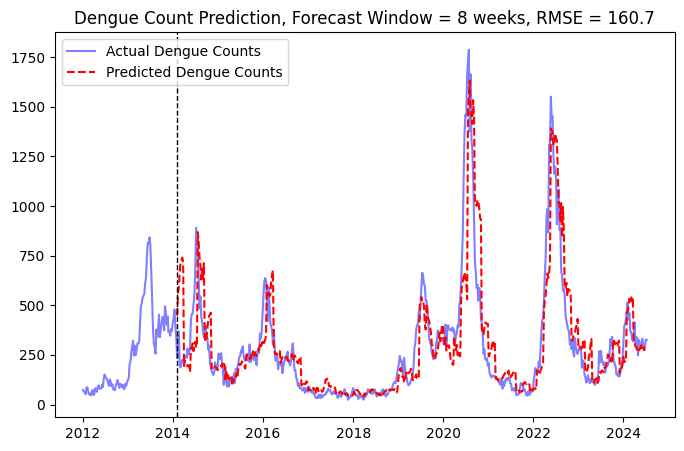

In [31]:
# PLOT FOR PPT, NOT NOTEBOOK. TO REMOVE
# Create dataframe with lagged values for tabular approach
df_tab = df_raw.copy()
target_lags = range(1, 6)                                         # Lagged values to use for target, i.e. dengue count
feature_lags = np.array([3,4])                                        # Lagged values to use for features
lagged_features = ['Daily_Rainfall', 'Mean_Temperature', 'Relative_Humidity',
                   'Max_Temperature', 'Min_Temperature', 'Min_Wind_Speed',
                   'Max_Wind_speed', 'Trend_Dengue', 'Trend_Dengue_Symptoms',
                   'Trend_Fever', 'Trend_Mosquito','Wolbachia_Ratio','External_Events']

# Add feature lags
for feat in lagged_features:
    for lag in feature_lags:
        df_tab[f'{feat}_Lag_{lag}'] = df_tab[feat].shift(lag)
        
# Add target lags
dict_target_lags = {}                                             # Keep track of lagged target names
for lag in target_lags:
    dict_target_lags[lag] = f'Dengue_Count_Lag_{lag}'
    df_tab[dict_target_lags[lag]] = df_tab['Dengue_Count'].shift(lag)    

# Create feature and target dataframes
df_features = df_tab.copy()[[col for col in df_tab.columns if not (col in ['Year','Dengue_Count'])]]
df_target = df_tab.copy()[['Dengue_Count']]

# Define parameters for XGBoost
params = {
    'learning_rate': 0.1,
    'n_estimators': 1000,
    'max_depth': 8,
    'min_child_weight': 1,
    'gamma': 0.6,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'reg_lambda': 1,
    'reg_alpha': 1,
    'objective': 'reg:squarederror',
    'random_state': 42,
    'device':'cuda',
    'tree_method':'hist'
}

# Collect predictions
preds = []
for i, (train_ind,test_ind) in enumerate(tscv.split(df_features)):
    # Initialize XGBoost regressor with defined parameters
    model = xgb.XGBRegressor(**params)

    # Train the model
    model.fit(df_features.iloc[train_ind,:], df_target.iloc[train_ind])

    # Get prediction
    y_pred = get_sequential_predictions(model, df_features.iloc[test_ind,:],
                                    dict_target_lags=dict_target_lags)
    y_pred = pd.DataFrame(y_pred,columns=['Dengue_Count'],index=df_features.iloc[test_ind,:].index)
    preds.append(y_pred)

df_preds_xgb = pd.concat(preds)
rmse = np.sqrt(mean_squared_error(df_target.loc[df_preds_xgb.index],df_preds_xgb))

# Plot
fig,ax = plt.subplots(1,1,figsize=(8,5))
ax.plot(df_target,'b',label='Actual Dengue Counts',alpha=0.5)
ax.plot(df_preds_xgb,'r--',label='Predicted Dengue Counts')
ax.axvline(x=df_preds_xgb.index[0], color='k', linestyle='--', linewidth=1)
ax.legend()
ax.set_title(f'Dengue Count Prediction, Forecast Window = 8 weeks, RMSE = {rmse:.1f}')

### Model Comparison

As shown in the model comparison below, the XGBoost model outperforms both linear regression and SARIMAX for the task at hand. As such, the XGBoost model is selected for further refinement below.

In [27]:
# Add comparison code

## XGBoost Model Refinement

We refine the XGBoost model here with the following additional considerations:
1. Using lagged labels from the past 5 weeks may worsen prediction, as erroneous predictions early in the forecast window may accumulate rapidly and affect predictions later in the window. Considering a higher auto-correlation for time points closer to each other, target lags of 1 and 2 weeks are most likely bring about this phenomenon. Based on findings from experimentation, the final model adopts a target lag of 3 and 4 weeks. This configuration takes advantage of the predictive power of past target values, without overrelying on them for a good prediction.
2. As with the target values, we do not necessarily have foreknowledge of the features in the forecast window, especially for google search trends and weather conditions. For the evaluation below, we use mean historical values for these features. As Wolbachia efforts and external events (i.e. pandemic related lockdowns and heightened construction activities) are controlled by the authorities, we consider these as known values.

In [28]:
# Define lag characteristics
feature_lags = range(1, 6)
lagged_features = ['Daily_Rainfall', 'Mean_Temperature', 'Relative_Humidity',
                   'Max_Temperature', 'Min_Temperature', 'Min_Wind_Speed',
                   'Max_Wind_speed', 'Trend_Dengue', 'Trend_Dengue_Symptoms',
                   'Trend_Fever', 'Trend_Mosquito','Wolbachia_Ratio','External_Events']
weak_features = ['Daily_Rainfall', 'Mean_Temperature', 'Relative_Humidity',
                   'Max_Temperature', 'Min_Temperature', 'Min_Wind_Speed',
                   'Max_Wind_speed', 'Trend_Dengue', 'Trend_Dengue_Symptoms',
                   'Trend_Fever', 'Trend_Mosquito'] # Features for which historical mean values are taken in forecast window
target_lags = np.array([3,4])

Text(0.5, 1.0, 'Dengue Count Prediction, Forecast Window = 8 weeks, RMSE = 182.3')

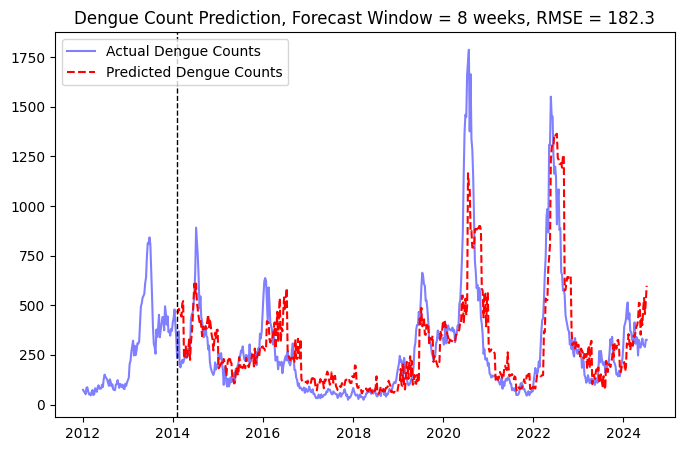

In [29]:
preds = [] # Collect predictions
for train_ind, test_ind in tscv.split(df_raw):
    all_ind = np.hstack([train_ind, test_ind])
    df_tab = df_raw.copy().iloc[all_ind,:]

    # Prep train features with lagged features and target values
    # Add feature lags
    X_train = df_tab.iloc[train_ind,:]
    for feat in lagged_features:
        for lag in feature_lags:
            X_train[f'{feat}_Lag_{lag}'] = X_train[feat].shift(lag)

    # Add target lags
    dict_target_lags = {}
    for lag in target_lags:
        dict_target_lags[lag] = f'Dengue_Count_Lag_{lag}'
        X_train[dict_target_lags[lag]] = X_train['Dengue_Count'].shift(lag)
    X_train = X_train[[col for col in X_train.columns if not (col in ['Year','Dengue_Count'])]]

    # Prep train labels
    y_train = df_tab.iloc[train_ind,:].loc[:,'Dengue_Count']

    # Create dataframe of historical mean of selected features from train set
    X_train_temp = df_tab.copy().iloc[train_ind,:]
    mean_feature_values = []
    for feat in weak_features:
        mean_feature_values.append(X_train_temp[['Week',feat]].groupby('Week').mean())
    mean_feature_values = pd.concat(mean_feature_values,axis=1)

    # Replace selected 'known' feature values with historical mean
    df_w_mean = df_tab.copy().iloc[all_ind,:]
    df_w_mean.drop(columns=weak_features,inplace=True)
    df_w_mean = df_w_mean.merge(mean_feature_values,on='Week',how='left')
    
    # Add lagged features
    for feat in lagged_features:
        for lag in feature_lags:
            df_w_mean[f'{feat}_Lag_{lag}'] = df_w_mean[feat].shift(lag)
            
    # Add target lags
    for lag in target_lags:
        df_w_mean[dict_target_lags[lag]] = df_w_mean['Dengue_Count'].shift(lag)
    
    # Get test features and labels
    X_test = df_w_mean[[col for col in df_w_mean.columns if not (col in ['Year','Dengue_Count'])]]
    X_test = X_test.iloc[test_ind,:]
    X_test = X_test[X_train.columns]           # Get test feature columns in the same order as train df

    # Initialize XGBoost regressor with defined parameters
    model = xgb.XGBRegressor(**params)

    # Train the model
    model.fit(X_train, y_train)

    # Get prediction
    y_pred = get_sequential_predictions(model, X_test, dict_target_lags=dict_target_lags)
    y_pred = pd.DataFrame(y_pred,columns=['Dengue_Count'],index=df_features.iloc[test_ind,:].index)
    preds.append(y_pred)
    
df_preds_xgb = pd.concat(preds)
rmse = np.sqrt(mean_squared_error(df_target.loc[df_preds_xgb.index],df_preds_xgb))

# Plot
fig,ax = plt.subplots(1,1,figsize=(8,5))
ax.plot(df_target,'b',label='Actual Dengue Counts',alpha=0.5)
ax.plot(df_preds_xgb,'r--',label='Predicted Dengue Counts')
ax.axvline(x=df_preds_xgb.index[0], color='k', linestyle='--', linewidth=1)
ax.legend()
ax.set_title(f'Dengue Count Prediction, Forecast Window = 8 weeks, RMSE = {rmse:.1f}')

## Conclusion and Future Work

blah blah lorem ipsum